## Core

In [ ]:
#| default_exp core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from dotenv import load_dotenv
import os

In [ ]:
#| hide
load_dotenv();

In [ ]:
#| export
import json
from typing import List, Dict, Tuple
import textwrap
import claudette
from IPython import get_ipython
from IPython.display import display, clear_output, Markdown, Javascript
from friendlly.utils import ExecCBs

In [ ]:
#| export

# A single cell can contain multiple messages.
# A message is either a user message (starts with %fr) or a bot message (starts with #).
# Both can be multiline.
def parse_cell(
    cell: str # The raw body of the cell
) -> Tuple[List[Dict[str, str]], int]:
    """
    A single cell can contain multiple messages.
    A message is either a user message (starts with %fr) or a bot message (starts with #).
    Both can be multiline.

    Returns: a list of messages (with 'role' and 'content') and the number of %fr magics in the cell
    """
    parsed_lines = []
    num_magic = 0
    for line in cell.split('\n'):
        if line.startswith('%fr'):
            message = {'role': 'user', 'content': line[3:].strip()}
            num_magic += 1
        elif line.strip().startswith('#'):
            message = {'role': 'assistant', 'content': line[1:].strip()}
        else: continue

        if not parsed_lines or parsed_lines[-1]['role'] != message['role']:
            parsed_lines.append(message)
        else:
            parsed_lines[-1]['content'] += ("\n" + message['content'])

    return parsed_lines, num_magic

In [ ]:
#| exporti
#| hide

models = [
    'claude-3-opus-20240229',
    'claude-3-5-sonnet-20240620',
    'claude-3-haiku-20240307',
]
chat_client = claudette.Client(model=models[1])

magic_count = 0
messages = []

In [ ]:
#| export
def fr_line(line: str):
    """The magic function for the %fr magic command."""
    global magic_count, messages
    ip = get_ipython()
    # raw_cell = ip.history_manager.input_hist_raw[-1]
    raw_cell = ip.get_parent()["content"]["code"]

    # The cell might have multiple %lm magics, but we only want to process the last one.
    # Presumably, the previous ones would have been processed already.
    if magic_count <= 0:
        messages, magic_count = parse_cell(raw_cell)

    # This is the last %lm magic invocation of the cell.
    # But we ignore cells that don't have a user message as the last message.
    if magic_count == 1 and len(messages) > 0 and messages[-1]['role'] == 'user' and messages[-1]['content'].strip():
        reply = ""
        display_id = display(Markdown("🚀..."), display_id=True)
        try:
            r = chat_client([m['content'] for m in messages], stream=True)
            for token in r:
                reply += token
                display_id.update(Markdown(reply))

            if reply:
                reply = textwrap.fill(text=reply, width=100, initial_indent="# ", subsequent_indent="# ")
                raw_cell += f"\n{reply}\n\n%fr "
                ip.set_next_input(raw_cell, replace=True)

            clear_output()

        except BaseException as e:
            display_id.update(Markdown(f"🚫 {repr(e)}"))


    magic_count -= 1

## Friend**LL**y

In [ ]:
#| eval: False
ip = get_ipython()
ip.register_magic_function(fr_line, 'line', magic_name='fr')

In [ ]:
%fr Hello there! My name is Alex.

# Hello Alex! It's nice to meet you. How can I assist you today? Is there anything specific you'd
# like to talk about or any questions you have?

%fr

In [ ]:
from friendlly.utils.nbclassic import patch_kernel, add_cell, update_cell, render_cell, execute_cell, get_index

In [ ]:
#| export

sp="""
You are ConGusto, a very knowledgeable and intelligent research assistant.
Fulfill simple requests right away.
Use <thought>, it's not shown to the user. You can use <thought> multiple times.

When appropriate, use Jupyter notebook. It has python 3.10+ and many packages installed.
Use <code> to add a new code cell.
Use <run> to execute the added cell. You will receive all its output on the next turn.

Avoid putting too much in one cell. Prefer short cells that can be tested quickly.
This way you will be able to check that the cell works as intended and continue. 

You can use the usual display(), print(), or just place the value on the last line of the cell.
Make sure to not add anything after that value, as it won't be retuerned if it's not on the last line.
Only output a result once with one method.
Avid using .show() and close matplot figures before the end of the cell - use an explicit display().

After code execution, if the request has been fullfilled, reply only with <done>, do not explain the obvious.
The user will ask follow-up questions if needed. They want you to do only what they asked for.
You should also end your text with <done> if there is no need to run code.

To show an example in python without running the code, use
```python
python code here
```

For example:
User: Calculate square root of pi
Assistant: <code>
import math
math.sqrt(math.pi)
</code><run>
User: <stdio>1.7724538509055159<stdio>
Assistand: <done>

User: Display cat.jpg
Assistant: <thought>I can use the PIL library for this.</thought><code>
from PIL import Image
Image.open("cat.jpg")
</code><run>
User: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=128x127>
User: <image message>
Assistant: <done>

When writing code, use advanced python features.
Assume all packages are instlled.
Don't forget to import modules before using them.
If you realize that you need to use a module that is not imported, import in in place.
"""


In [ ]:
# from PIL import Image
# from pathlib import Path
# fn = Path("cat.jpg")
import cairosvg
import xml.etree.ElementTree as ET
from io import BytesIO
import base64

def svg_to_png(svg_content, max_size):
    root = ET.fromstring(svg_content)

    
    def parse_dimension(value):
        if value.endswith('%'):
            return float(value[:-1]) / 100 * max_size
        return float(re.findall(r'[\d.]+', value)[0])

    width = parse_dimension(root.attrib.get('width', str(max_size)))
    height = parse_dimension(root.attrib.get('height', str(max_size)))
    
    viewBox = root.attrib.get('viewBox')
    if viewBox:
        _, _, vb_width, vb_height = map(float, viewBox.split())
        if width == max_size:
            width = vb_width
        if height == max_size:
            height = vb_height

    scale = min(max_size / width, max_size / height)
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Render PNG
    png =  cairosvg.svg2png(bytestring=svg_content, output_width=new_width, output_height=new_height)
    return base64.b64encode(png)

def display_to_messages(dsp):
    plain_text = dsp.get("text/plain")
    text = list(filter(lambda x:x[1], [
        ("text-html", dsp.get("text/html")),
        ("latex", dsp.get("text/latex")),
        ("markdown", dsp.get("text/markdown")),
        ("json", dsp.get("application/json")),
        ("js", dsp.get("application/javascript"))
    ]))
    
    images = list(filter(lambda x:x, [ dsp.get("image/png"), dsp.get("image/jpeg") ]))
    svg = dsp.get("image/svg+xml")
    if svg: images.append(svg_to_png(svg, 256))
  
    messages = [f"<{t[0]}>{t[1]}</{t[0]}>" for t in text]
    
    if not len(messages):
        messages = [plain_text]
        
    claudette_msgs = [claudette.text_msg(m) for m in messages]
    if images:
        claudette_msgs.append(claudette.img_msg(base64.b64decode(images[0]))) # Grab only one image

    return claudette_msgs


In [ ]:
#| export

class CellChat():
    def __init__(self, model="claude-3-5-sonnet-20240620", sp=None):
        if sp is not None: self.sp = sp
        self.history = []
        self.client = claudette.Client(model=model)


    def update_markdown(self, text):
        if self.md_idx is None:
            self.md_idx = self.idx+1
            add_cell(self.md_idx, "markdown")
        update_cell(self.md_idx, text)
        render_cell(self.md_idx)

    def update_code(self, code):
        if self.code_idx is None:
            self.code_idx = self.md_idx+1 if (self.md_idx is not None) else self.idx+1
            add_cell(self.code_idx, "code")
        update_cell(self.code_idx, code)

    def go(self, idx, message, autorun=True):
        assert idx >= 0
        self.idx = idx
        self.md_idx = self.code_idx = None
        self.history.append(message)
        
        tokens = []
        try:
            md_reply = ""
            code_reply = None
            add_md_cell = True
            r = self.client(claudette.mk_msgs(self.history),
                            sp=self.sp,
                            stream=True,
                            stop=["</code>"])
            for token in r:
                tokens.append(token)
                
                md_reply += token
                if "<code>" in md_reply:
                    md_reply, code_reply = md_reply.split("<code>")

                if md_reply != "":
                    self.update_markdown(md_reply.strip())
                if code_reply is not None:
                    break

            if code_reply is not None:
                for token in r:
                    tokens.append(token)
                    code_reply += token
                    prefix = f"%%fr +{self.code_idx - self.idx} reply\n" if self.code_idx else "%%fr reply"
                    self.update_code(prefix + code_reply.strip())
                
            if self.client.stop_reason == "stop_sequence":
                tokens += self.client.stop_sequence
            self.history.append(claudette.mk_msg("".join(tokens), role="assistant"))
            
            if autorun and self.code_idx is not None:
                # This schedules the cell for execution once this one is finished.
                execute_cell(self.code_idx)
                return True
            
        except BaseException as e:
            raise e
#             display(Markdown(f"🚫 {repr(e)}"))
#             get_ipython().showtraceback()



In [ ]:
import json
from datetime import datetime

class GenericEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, datetime):
            return obj.isoformat()
        try:
            return obj.__dict__
        except AttributeError:
            try:
                return str(obj)
            except:
                return f"<{type(obj).__name__}>"

# # Usage
# data = {"date": datetime.now(), "complex": 1+2j, "custom": object()}
# json.dumps(data, cls=GenericEncoder)


In [ ]:
chat = None
cbs = None


import cairosvg
from io import BytesIO

def followup(stdout, stderr, dsp, result, tracebacks):
    text_message = ""
    
    assert len(tracebacks) <= 1
    if result.error_before_exec:
        text_message += "<error_before_exec>" + tracebacks[0]["stb"] + "</error_before_exec>"
    
    if result.error_in_exec:
        text_message += "<error_in_exec>" + tracebacks[0]["stb"] + "</error_in_exec>"
    
    if stdout: text_message += f"<stdout>{stdout}</stdout>"
    if stderr: text_message += f"<stderr>{stderr}</stderr>"
        
    if dsp is None: dsp = []
    display_messages = []
    for d in dsp:
        msgs = display_to_messages(d)
        for msg in msgs:
            display_messages.append(msg)

        
    result_message = []
    if result.result:
        formatted, _ = get_ipython().display_formatter.format(result.result)
        for key in ("image/jpg", "image/png"):
            if key in formatted: formatted[key] = base64.b64encode(formatted[key]).decode("ascii")

        result_message = display_to_messages(formatted)
        
    combined_messages = []
    if text_message: combined_messages += [claudette.text_msg(text_message)]
    if display_messages: combined_messages += display_messages
    if result_message: combined_messages += result_message
#     raise ValueError
    message = claudette.mk_msg(combined_messages)
    
#     raise "hello"
    to_exec = chat.go(get_index(), message)
    if to_exec:
            cbs = ExecCBs(followup)
            cbs.register()

def fr_cell(line=None, cell=None):
    global cbs
    global chat
    print(line, cell)
#     chat = CellChat(sp=sp)
    ip = get_ipython()
#         ip = get_ipython()
#         print(ip.parent_header)
    
#     n = 0
#     if line and "+" in line:
#         _, arg = line.split("+")
#         arg, _ =line.split() # split on space/tab
#         n = int(arg)
        
#     print(json.dumps(ip.parent_header, indent=2, cls=GenericEncoder))
    return ip.parent_header
    
#     if not line:
#         to_exec = chat.go(get_index(), claudette.mk_msg(cell, role="user"))
#     else:
#         ip.run_cell(cell)
        # Collect history...
        # Run chat on the cell outputs...
        
#         exec(cell, globals())
#     if to_exec:
#         cbs = ExecCBs(followup)
#         cbs.register()

get_ipython().register_magic_function(fr_cell, 'cell', magic_name='fr')
# patch_kernel()

In [ ]:
#| export

# def load_ipython_extension(ipython):
#     patch_kernel()
#     ipython.register_magic_function(fr_line, 'line', magic_name='fr')
#     ipython.register_magic_function(fr_cell, 'cell', magic_name='fr')

# def unload_ipython_extension(ipython):
#     if cbs: cbs.unregister()

In [ ]:
#| eval: false
# load_ipython_extension(get_ipython())

In [ ]:
from friendlly.utils.nbclassic import patch_kernel
patch_kernel()

<IPython.core.display.Javascript object>

In [ ]:
from friendlly.utils.misc import nict
from friendlly.utils.capture_trace import strip_junk
from claudette import text_msg, img_msg, mk_msg

In [ ]:
%%fr +1
Download and show an image of a cat

+1 Download and show an image of a cat



{'header': {'date': datetime.datetime(2024, 7, 22, 8, 28, 29, 294000, tzinfo=tzutc()),
  'msg_id': '0b20a3efa0b94b3caf7f44b6d99e53c5',
  'username': 'username',
  'session': 'f99ab87e1c6547f5886ea7f71f5805b6',
  'msg_type': 'execute_request',
  'version': '5.2'},
 'msg_id': '0b20a3efa0b94b3caf7f44b6d99e53c5',
 'msg_type': 'execute_request',
 'parent_header': {},
 'metadata': {},
 'content': {'code': '%%fr +1\nDownload and show an image of a cat',
  'silent': False,
  'store_history': True,
  'user_expressions': {},
  'allow_stdin': True,
  'stop_on_error': True,
  'cells_above': [{'metadata': {'trusted': True},
    'cell_type': 'code',
    'source': 'from friendlly.utils.misc import nict\nfrom friendlly.utils.capture_trace import strip_junk\nfrom claudette import text_msg, img_msg, mk_msg',
    'execution_count': 13,
    'outputs': []}],
  'cell_index': 22,
  'cell_id': '7f1f30b4'},
 'buffers': []}

Certainly! I'll download an image of a cat using the requests library and then display it using PIL (Python Imaging Library). Here's how we can do that:

hello


'workld'

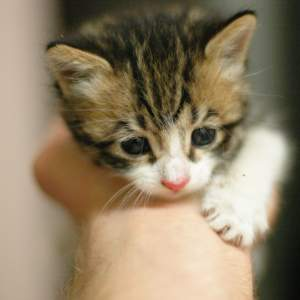

In [ ]:
# %%fr +2 reply
import requests
from PIL import Image
from io import BytesIO

# URL of a cat image (using a placeholder image service)
url = "https://placekitten.com/300/300"

print("hello")
display("workld")

# Download the image
response = requests.get(url)

# Open the image using PIL
img = Image.open(BytesIO(response.content))

# try:
#     1/0
# except e:
#     raise ValueError("Hello?")

# Display the image
img

In [ ]:
%%fr +3 reply

test

{'header': {'date': datetime.datetime(2024, 7, 22, 7, 52, 1, 64000, tzinfo=tzutc()),
  'msg_id': 'a7c0793fd4c44ce3956118c8a12fa2f2',
  'username': 'username',
  'session': 'f99ab87e1c6547f5886ea7f71f5805b6',
  'msg_type': 'execute_request',
  'version': '5.2'},
 'msg_id': 'a7c0793fd4c44ce3956118c8a12fa2f2',
 'msg_type': 'execute_request',
 'parent_header': {},
 'metadata': {},
 'content': {'code': '%%fr +3 reply\n\ntest',
  'silent': False,
  'store_history': True,
  'user_expressions': {},
  'allow_stdin': True,
  'stop_on_error': True,
  'cells_above': [{'metadata': {'trusted': True},
    'cell_type': 'code',
    'source': '%%fr +1\nDownload and show an image of a cat',
    'execution_count': None,
    'outputs': []},
   {'metadata': {},
    'cell_type': 'markdown',
    'source': "Certainly! I'll download an image of a cat using the requests library and then display it using PIL (Python Imaging Library). Here's how we can do that:"},
   {'metadata': {'trusted': True},
    'cell_type'

In [ ]:
header = nict(_)

In [ ]:
def safe_int(s, default=0):
    try:
        return int(s)
    except ValueError:
        return default

def display_data_to_messages(dsp):
    plain_text = dsp.get("text/plain")
    text = list(filter(lambda x:x[1], [
        ("text-html", dsp.get("text/html")),
        ("latex", dsp.get("text/latex")),
        ("markdown", dsp.get("text/markdown")),
        ("json", dsp.get("application/json")),
        ("js", dsp.get("application/javascript"))
    ]))
    
    images = list(filter(lambda x:x, [ dsp.get("image/png"), dsp.get("image/jpeg") ]))
    svg = dsp.get("image/svg+xml")
    if svg: images.append(svg_to_png(svg, 256))
  
    messages = [f"<{t[0]}>{t[1]}</{t[0]}>" for t in text]
    
    if not len(messages):
        messages = [plain_text]
        
    claudette_msgs = [text_msg(m) for m in messages]
    if images:
        claudette_msgs.append(img_msg(base64.b64decode(images[0]))) # Grab only one image

    return claudette_msgs
    
def parse_cell_line(line):
    num_cells, is_reply, is_friendlly = 0, False, False
    if line.lstrip('# \t').rstrip().startswith("%%fr"):
        is_friendlly = True
        args = line.split()
        for arg in args[1:]:
            if "+" in arg: num_cells = safe_int(arg[1:])
            if arg == "reply": is_reply = True

    return num_cells, is_friendlly, is_reply

def parse_above_cell(cell):
    assert "source" in cell
    if cell.cell_type != "code":
        assert not "outputs" in cell or not len(cell.outputs), "Got a non-code cell with outputs??"
        return False, False, text_msg(cell.source), []

    num_cells = 0
    is_reply = False
    is_friendlly = False
    code_blk = None
    output_blks = []
    
    lines = cell.source.strip().splitlines()
    if lines:
        num_cells, is_friendlly, is_reply = parse_cell_line(lines[0])
        
        # Remove the cell magic
        if is_friendlly:
            lines = lines[1:]
        code_text = "\n".join(lines)
        
        outputs = cell.get("outputs", [])
        for o in outputs:
            if o.output_type == "stream":
                output_blks.append(text_msg(f"<{o.name}>{o.text}</{o.name}>"))
            if o.output_type in ("display_data", "execute_result"):
                output_blks += display_data_to_messages(o.data)
            if o.output_type == "error":
                output_blks.append(text_msg("<error>" + strip_junk("\n".join(o.traceback)) + "</error>"))


    
        return is_friendlly, is_reply, code_text, output_blks
    return False, False, None, []

In [ ]:
def cells_to_messages(cells):
    messages = []
    
    
    # We found the first %%fr message (request from user).
    # This means that we treat further cells (markdown and code without %%fr) as assistant-generated.
    user_message_found = False
    for cell in cells:
        cell_friendlly, cell_reply, code_text, output_blks = parse_above_cell(cell)

        if code_text:
            # If the cell is marked with %%fr reply, or we found the user request above.
            if cell_reply:       role="assistant"  # Messages has '%%fr reply'
            elif cell_friendlly: role="user" # Message has %%fr without 'reply'
            else:                role="assistant" if user_message_found else "user" # It's not an %%fr cell.

            # We found an %%fr cell that is not a reply - means it's a user message!
            if cell_friendlly and not cell_reply: user_message_found=True

            # Assistant code gets wrapped into tags, user code gets wrapped into ```
            # Markdown is passed as is.
            if role == "assistant" and cell.cell_type == "code":
                code_text = f"<code>{code_text}</code>"
            elif role == "user":
                code_text = f"```\n{code_text}\n```"
            
            messages.append(mk_msg([code_text], role=role))

        # Outputs for both user and assistant code cells are always user messages.
        if output_blks:
            messages.append(mk_msg(output_blks, role="user"))
         
    return [nict(m) for m in messages]

In [ ]:
messages = cells_to_messages(header.content.cells_above)
messages

[{'role': 'user',
  'content': [{'type': 'text',
    'text': '```\nDownload and show an image of a cat\n```'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': "Certainly! I'll download an image of a cat using the requests library and then display it using PIL (Python Imaging Library). Here's how we can do that:"}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': '<code>import requests\nfrom PIL import Image\nfrom io import BytesIO\n\n# URL of a cat image (using a placeholder image service)\nurl = "https://placekitten.com/300/300"\n\nprint("hello")\ndisplay("workld")\n\n# Download the image\nresponse = requests.get(url)\n\n# Open the image using PIL\nimg = Image.open(BytesIO(response.content))\n\n# try:\n#     1/0\n# except e:\n#     raise ValueError("Hello?")\n\n# Display the image\nimg</code>'}]},
 {'role': 'user',
  'content': [{'type': 'text', 'text': '<stdout>hello\n</stdout>'},
   {'type': 'text', 'text': "'workld'"},
   {'type': 'text',
    

In [ ]:
def merge_messages(msgs):

    # first, merge by role
    role_messages = []
    prev_role = None

    for m in msgs:
        if prev_role == m.role: role_messages[-1].content += m.content
        else:                   role_messages.append(m)
        prev_role = m.role

    # Then, for assistant, also coalesce text messages together
    for m in role_messages:
        merged_content = []
        for c in m.content:
            if c.type == "text" and merged_content and merged_content[-1].type == "text":
                merged_content[-1].text += ("\n" + c.text)
            else: merged_content.append(c)
        m.content = merged_content
    return role_messages
        

In [ ]:
merge_messages(messages)

[{'role': 'user',
  'content': [{'type': 'text',
    'text': '```\nDownload and show an image of a cat\n```'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Certainly! I\'ll download an image of a cat using the requests library and then display it using PIL (Python Imaging Library). Here\'s how we can do that:\n<code>import requests\nfrom PIL import Image\nfrom io import BytesIO\n\n# URL of a cat image (using a placeholder image service)\nurl = "https://placekitten.com/300/300"\n\nprint("hello")\ndisplay("workld")\n\n# Download the image\nresponse = requests.get(url)\n\n# Open the image using PIL\nimg = Image.open(BytesIO(response.content))\n\n# try:\n#     1/0\n# except e:\n#     raise ValueError("Hello?")\n\n# Display the image\nimg</code>'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': "<stdout>hello\n</stdout>\n'workld'\n<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x300>"},
   {'type': 'image',
    'source': {'type': 'base64',
 

In [ ]:
def fr_cell(line=None, cell=None):
    num_cell, is_friendlly, is_reply = 0, False, False

    ip = get_ipython()
    header = nict(ip.parent_header)
    
    prev_messages = []
    if line:
        num_cells, is_friendlly, is_reply = parse_cell_line(line)
        assert is_friendlly, "Called on a cell without %%fr?"
        assert num_cell == len(header.content.cells_above), "Jupyter did not send the required cells"

        prev_messages = merge_messages(cells_to_messages(header.content.cells_above))
    
        # A conversation can't start with an assistant message.
        if prev_messages and prev_messages[0].role == "assistant"
            prev_messages.insert(0, mk_msg("(Beginning of the conversation truncated)", role="user"))
    
    # If it's a user message, we should pass the message history to the chat along with the cell,
    # and it will generate more output.
    
    # If it's a folllow-up message, we should first run the current cell and collect its outputs,
    # then pass the outputs to the chat as user messages for further generation.
    
    
    
    global cbs
    global chat
    chat = CellChat(sp=sp)
    
    
    
    
get_ipython().register_magic_function(fr_cell, 'cell', magic_name='fr')
patch_kernel()

In [ ]:
header.content.cells_above[1]

In [ ]:
a = [1,2,2]
a.insert(0, 3)
a

[3, 1, 2, 2]